In [176]:
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [205]:
results_path = "/data/users/taylorrobie/repos/pytorch/aten/src/ATen/native/autotune/test_scripts/results.txt"
NATIVE = "Conv2D_Native"
NNPACK = "Conv2D_NNPack"
MKL = "Conv2D_MKL"

results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
all_shapes_set = set()
all_shapes = []
with open(results_path, "rt") as f:
    for i, l in enumerate(f):
        bandit, shapes, impl, run_time = [i.strip() for i in l.strip().split("    ")]
        
        if shapes not in all_shapes_set:
            all_shapes.append(shapes)
            all_shapes_set.add(shapes)
            
        results[bandit][shapes][impl].append((i, int(run_time)))


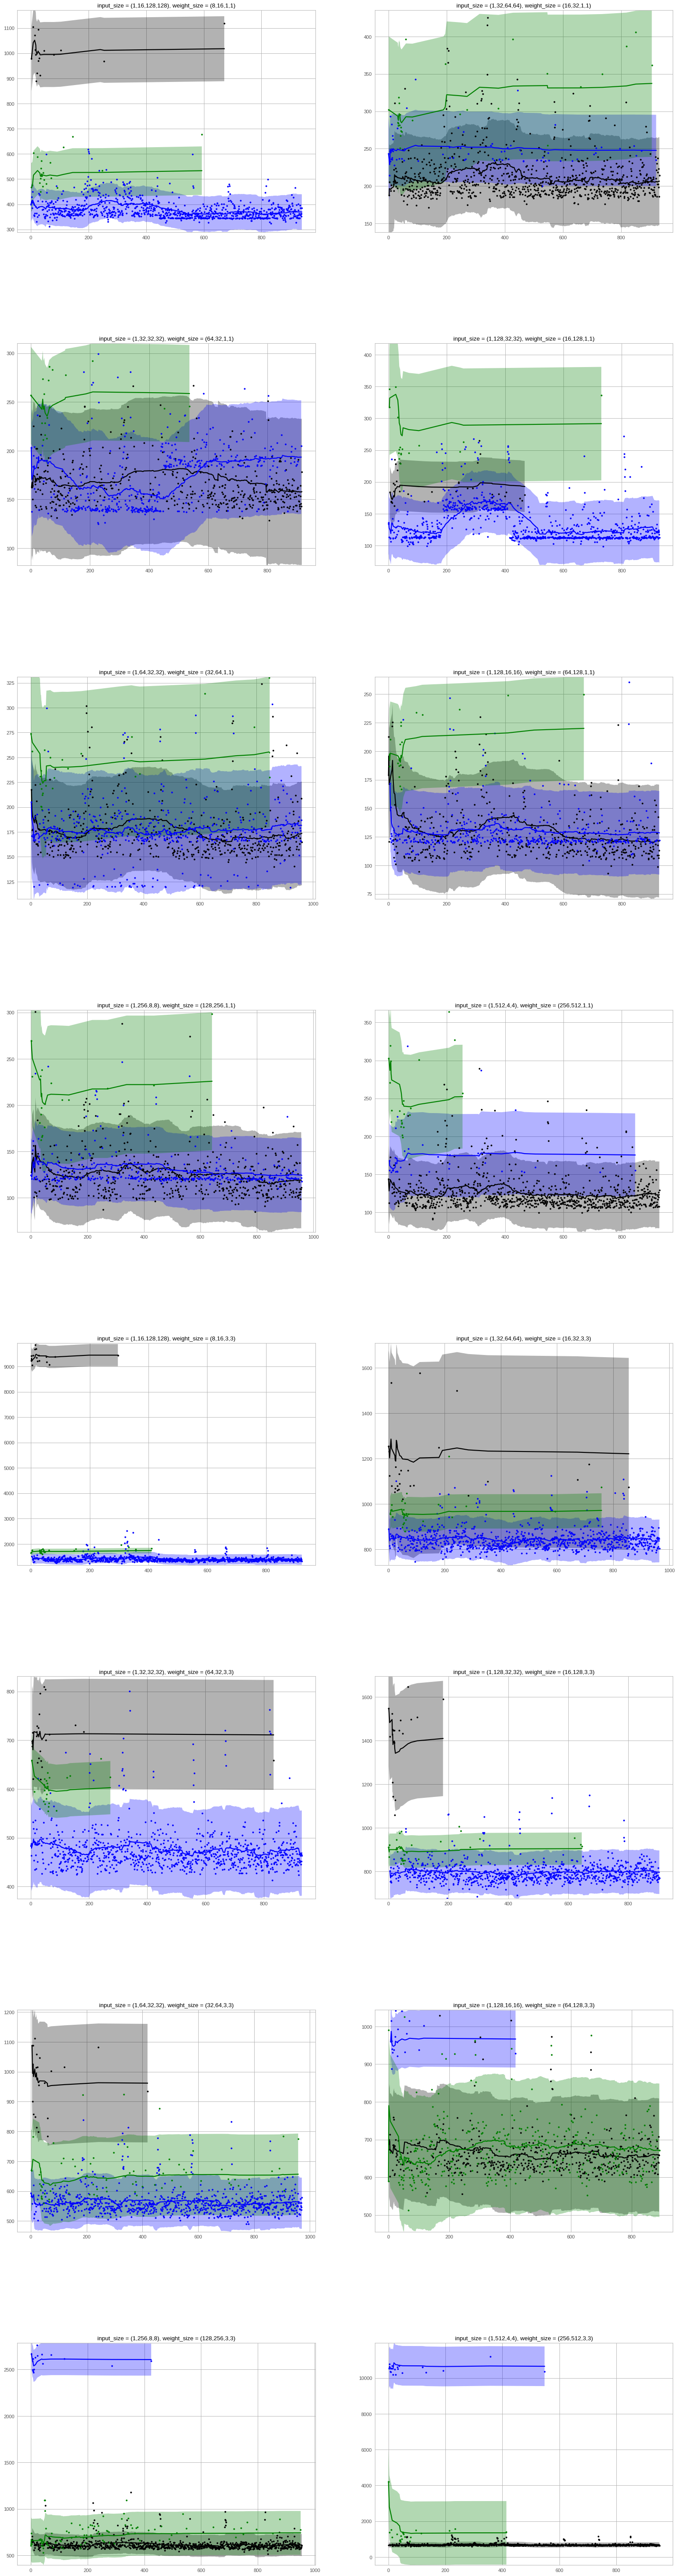

In [211]:
window = 100
fig=plt.figure(figsize=(24, 96), dpi= 80, facecolor='w', edgecolor='k')

# BANDIT = "DrunkenBandit"
BANDIT = "GaussianBandit"
for shape_choice in range(16):
    plt.subplot(8, 2, shape_choice + 1)
    shape_str = all_shapes[shape_choice]
    
    r_by_impl = {
        impl : [ri for ri in results[BANDIT][shape_str][impl]]
        for impl in [NATIVE, NNPACK, MKL]
    }
    raw_x_ind = []
    for r in r_by_impl.values():
        raw_x_ind.extend([ri[0] for ri in r])
    raw_x_ind.sort()
    x_ind_map = {xi: i for i, xi in enumerate(raw_x_ind)}
    color_map = {NATIVE: "k", NNPACK: "b", MKL: "g"}
    lower_bound, upper_bound = 1e10, 0
    
    for impl, r in r_by_impl.items():
        x = np.array([x_ind_map[xi] for xi, _ in r])
        y = np.array([yi * 1e-3 for _, yi in r])
        n = len(r)
        
        running_mean, running_std = [], []
        for i in range(n):
            y_subset = y[max(0, i + 1 - window):i + 1]
            running_mean.append(np.mean(y_subset))
            running_std.append(np.std(y_subset))
        running_mean, running_std = np.array(running_mean), np.mean(running_std)
        y_lower = running_mean - running_std * 2
        y_upper = running_mean + running_std * 2
        
        lower_bound = min(lower_bound, np.min(y_lower[3:]))
        upper_bound = max(upper_bound, np.max(y_upper[3:]))

        color = color_map[impl]
        plt.plot(x, y, "." + color, markersize=5)
        plt.plot(x, running_mean, color, linewidth=2)
        plt.fill_between(x, y_lower, y_upper, facecolor=color, alpha=0.3)
    plt.title(shape_str.replace("Convolution: ", ""), fontdict={"fontsize": 12})
    plt.ylim(bottom=lower_bound, top=upper_bound)
